In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.preprocessing import PolynomialFeatures
import scipy as scp
import scipy.stats as ss
from scipy.optimize import minimize
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.special as scsp
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator
from MarketUtils import *
import pyfolio as pf
from datetime import datetime
from ouparams import ouparams
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
from scipy.optimize import minimize
from scipy.integrate import quad
import sys
from collections import deque
from IStrategy import IStrategy
import pandas as pd
import pyvinecopulib as pv
from ouparams import ouparams
from copulas.multivariate import  VineCopula

c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


c:\Users\Lakshay Garg\Dropbox\My PC (LAPTOP-INHAMB7E)\Desktop\IAQF 2023\IAQF_2023\CleanCode\DataFiles\index_prices.csv


c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
#Get Data and set parameters
indices = ['^GSPC', '^IXIC']

#Don't change this, we will keep the rest of the data as test data
# termDates = ['01-01-2002','01-01-2015']
termDates = ['01-01-1993','01-01-2022']
price_data = get_data(type ='index',col_list = indices, termDates = termDates)
# alter_data = get_data(type = 'alter', termDates=termDates)
# price_data = price_data.loc[alter_data.index.values]
# alter_data["Flat"] = alter_data['Yield_30Y'] - alter_data['fedfunds']
# alter_data["vol_spread"] = alter_data[indices[0]] - alter_data[indices[1]]
# alter_data["vix"] = alter_data[indices[0]]
# alter_cols = ['fedfunds','vix','vol_spread','Flat','News Sentiment']
# alter_data = alter_data[alter_cols]

# can change this as per your requirement
spy = price_data[indices[0]]
qqq = price_data[indices[1]]
spy_price = np.array(spy)
qqq_price = np.array(qqq)
spy_normal = (spy_price - np.mean(spy_price))/np.std(spy_price)
qqq_normal = (qqq_price - np.mean(qqq_price))/np.std(qqq_price)
actual_spread = spy_normal-qqq_normal

#Train, Test split
x = np.array(spy_price)
y = np.array(qqq_price)
alter_data = alter_data.values

#trading params
formation = 63
trading_period = 42

In [4]:
def OUFit(spread):
    mu, sigma, theta = ouparams.find(spread)
    return np.log(2)/theta
    if abs(np.log(2)/theta) < 100: 
        return np.log(2)/theta
    return np.inf

In [5]:
def get_train_spread(x_train, y_train):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    return pre_spread

In [6]:
def dummy_strategy_l(x_train, y_train, x_test, y_test):
    return np.zeros(len(y_test)), np.ones(len(y_test))

def dummy_strategy_s(x_train, y_train, x_test, y_test):
    return np.zeros(len(y_test)), -np.ones(len(y_test))

In [7]:
def get_train_spread(x_train, y_train):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    return pre_spread

def get_strategy_ml_rm(x_train, y_train, x_test, y_test, close = False):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    half_life = OUFit(pre_spread)
    std = np.std(pre_spread)
    
    #Backtesting
    poly_features = poly.transform(x_test.reshape(-1, 1))
    y_test_pred = clf_Lasso.predict(poly_features)
    #Calculate spread and z-score for testing data
    spread = y_test_pred - y_test
    z_score = spread/std

    #Get Strategy with Risk Management
    strategy = np.zeros(len(z_score))
    holding_days = 0
    for i in range(1,len(z_score)):
        #If in last trading period, exit when remaining time for trading is less than 2 half-life
        if close == True:
            if half_life <= 0 or len(z_score)-i < 2*half_life:
                strategy[i] = 0
                holding_days = 0
                return z_score, strategy
                
        if z_score[i] > 2 or (strategy[i-1] == -1 and z_score[i] > np.mean(z_score)):
            strategy[i] = -1
            holding_days += 1
            
        elif z_score[i] < -2 or (strategy[i-1] == 1 and z_score[i] < np.mean(z_score)):
            strategy[i] = 1 
            holding_days += 1
        
        else:
            holding_days = 0
            
        #If holding period is longer than 2 half-life, exit
        if holding_days > 2*half_life:
            strategy[i] = 0
            holding_days = 0
               
    return z_score, strategy

In [8]:
def get_strategy_ml(x_train, y_train, x_test, y_test, isconver=True):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    scalar_spread = StandardScaler()
    pre_spread = scalar_spread.fit_transform(pre_spread.reshape(-1,1))
    half_life = OUFit(pre_spread)
    
    #Backtesting
    poly_features = poly.transform(x_test.reshape(-1, 1))
    y_test_pred = clf_Lasso.predict(poly_features)
    #Calculate spread and z-score for testing data
    spread = y_test_pred - y_test
    z_score = scalar_spread.transform(spread.reshape(-1,1))

    #Get Strategy with Risk Management
    strategy = np.zeros(len(z_score))
    if isconver:
        for i in range(1,len(z_score)):     
            if z_score[i] > 2 or (strategy[i-1] == -1 and z_score[i] > 0):
                strategy[i] = -1
                
            elif z_score[i] < -2 or (strategy[i-1] == 1 and z_score[i] < 0):
                strategy[i] = 1 
    else:
        for i in range(1,len(z_score)):     
            if z_score[i] > 2 and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif z_score[i] < -2 and strategy[i-1] == 0:
                strategy[i] = -1 
                
            elif strategy[i-1] == 1 and z_score[i] < 4:
                 strategy[i] = 1

            elif strategy[i-1] == -1 and z_score[i] > -4:
                 strategy[i] = -1
               
    return z_score, strategy

In [9]:
def get_strategy_coint(x_train, y_train, x_test, y_test, isconver = True):
    #Get standard deviation for historical spread
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train,y_train)
    spreads =  y_train - model.predict(x_train)
    scaler_spread = StandardScaler()
    spreads = scaler_spread.fit_transform(spreads.reshape(-1, 1))
    
    #Backtesting
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test_pred = model.predict(x_test)
    spread = y_test_pred - y_test
    z_score = scaler_spread.transform(spread.reshape(-1, 1))
    strategy = np.zeros(len(z_score))
    
    if isconver:
        for i in range(1,len(z_score)):     
            if z_score[i] > 2 or (strategy[i-1] == -1 and z_score[i] > 0):
                strategy[i] = -1
                
            elif z_score[i] < -2 or (strategy[i-1] == 1 and z_score[i] < 0):
                strategy[i] = 1 
    else:
        for i in range(1,len(z_score)):     
            if z_score[i] > 2 and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif z_score[i] < -2 and strategy[i-1] == 0:
                strategy[i] = -1 
                
            elif strategy[i-1] == 1 and z_score[i] < 4:
                 strategy[i] = 1

            elif strategy[i-1] == -1 and z_score[i] > -4:
                 strategy[i] = -1

    return z_score, strategy

def get_strategy_coint_rm(x_train, y_train, x_test, y_test, isconver=True):
    #Get standard deviation for historical spread
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train,y_train)
    spreads =  y_train - model.predict(x_train)
    scaler_spread = StandardScaler()
    spreads = scaler_spread.fit_transform(spreads.reshape(-1, 1))
    half_life = OUFit(spreads)

    isconver = (half_life > 0) and (6*half_life < trading_period)
    
    #Backtesting
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test_pred = model.predict(x_test)
    spread = y_test_pred - y_test
    z_score = scaler_spread.transform(spread.reshape(-1, 1))
    strategy = np.zeros(len(z_score))
    
    if isconver:
        for i in range(1,len(z_score)):     
            if z_score[i] > 2 or (strategy[i-1] == -1 and z_score[i] > 0):
                strategy[i] = -1
                
            elif z_score[i] < -2 or (strategy[i-1] == 1 and z_score[i] < 0):
                strategy[i] = 1 
    else:
        for i in range(1,len(z_score)):     
            if z_score[i] > 2 and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif z_score[i] < -2 and strategy[i-1] == 0:
                strategy[i] = -1 
                
            elif strategy[i-1] == 1 and z_score[i] < 4:
                 strategy[i] = 1

            elif strategy[i-1] == -1 and z_score[i] > -4:
                 strategy[i] = -1

    return z_score, strategy

In [10]:
def misprice_index(u,v,copula,theta):
        '''Calculate mispricing index for every day in the trading period by using estimated copula
        Mispricing indices are the conditional probability P(U < u | V = v) and P(V < v | U = u)'''

        if copula == 'clayton':
            MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
                        -1 / theta - 1)  # P(U<u|V=v)
            MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (
                        -1 / theta - 1)  # P(V<v|U=u)

        elif copula == 'frank':
            A = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * v) - 1)
            B = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * u) - 1)
            C = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)
            MI_u_v = B / C
            MI_v_u = A / C

        elif copula == 'gumbel':
            A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
            C_uv = np.exp(-A ** (1 / theta))  # C_uv is gumbel copula function C(u,v)
            MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
            MI_v_u = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(u)) ** (theta - 1) * (1.0 / u)

        return MI_u_v, MI_v_u

def _lpdf_copula(family, theta, u, v):
        '''Estimate the log probability density function of three kinds of Archimedean copulas
        '''

        if family == 'clayton':
            pdf = (theta + 1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1 / theta)) * (
                        u ** (-theta - 1) * v ** (-theta - 1))

        elif family == 'frank':
            num = -theta * (np.exp(-theta) - 1) * (np.exp(-theta * (u + v)))
            denom = ((np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)) ** 2
            pdf = num / denom

        elif family == 'gumbel':
            A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
            c = np.exp(-A ** (1 / theta))
            pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))

        return np.log(pdf)

def _parameter(family, tau):
        ''' Estimate the parameters for three kinds of Archimedean copulas
        according to association between Archimedean copulas and the Kendall rank correlation measure
        '''

        if family == 'clayton':
            return 2 * tau / (1 - tau)

        elif family == 'frank':
            '''
            debye = quad(integrand, sys.float_info.epsilon, theta)[0]/theta  is first order Debye function
            frank_fun is the squared difference
            Minimize the frank_fun would give the parameter theta for the frank copula 
            '''
            integrand = lambda t: t / (np.exp(t) - 1)  # generate the integrand
            frank_fun = lambda theta: ((tau - 1) / 4.0 - (
                        quad(integrand, sys.float_info.epsilon, theta)[0] / theta - 1) / theta) ** 2

            return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x[0]

        elif family == 'gumbel':
            return 1 / (1 - tau)

def get_strategy_copula2(x_train, y_train, x_test, y_test, isconver = True):
    #Get standard deviation for historical spread
    scaler = StandardScaler()
    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())
    u, v = [ecdfx(a) for a in x_train], [ecdfy(a) for a in y_train]
    tau = kendalltau(x_train, y_train)[0]  # estimate Kendall'rank correlation
    AIC = {}  # generate a dict with key being the copula family, value = [theta, AIC]
    s = ['clayton','frank', 'gumbel']
    for i in s:
        param = _parameter(i, tau)
        lpdf = [_lpdf_copula(i, param, x, y) for (x, y) in zip(u, v)]
        lpdf = np.nan_to_num(lpdf)
        loglikelihood = sum(lpdf)
        AIC[i] = [param, -2 * loglikelihood + 2]

    copula = min(AIC.items(), key=lambda x: x[1][1])[0]
    tau = kendalltau(x_train, y_train)[0]
    theta = _parameter('frank', tau)
    #Backtesting
    x_test = np.diff(np.log(x_test))[1:]
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test = np.diff(np.log(y_test))[1:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())
    
    M_x = np.array([misprice_index(x,y,copula,theta)[0] for x,y in zip(x_test,y_test)]) - 0.5
    M_y = np.array([misprice_index(x,y,copula,theta)[1] for x,y in zip(x_test,y_test)]) - 0.5
    flagx = M_x.cumsum()
    flagy = M_y.cumsum()

    #Get Strategy with Risk Management
    strategy = np.zeros(len(y_test))
    if isconver:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6) or (strategy[i-1] == -1 and (flagx[i] > 0 and flagy[i] < 0)):
                strategy[i] = -1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6) or (strategy[i-1] == 1 and (flagy[i] > 0 and flagx[i] < 0)):
                strategy[i] = 1 
    else:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6) and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6) and strategy[i-1] == 0:
                strategy[i] = -1

            elif strategy[i-1] == 1 and (flagx[i] > 2 and flagy[i] < -2):
                strategy[i] = 1

            elif strategy[i-1] == -1 and (flagy[i] > 2 and flagx[i] < -2):
                strategy[i] = -1
                         
    return (flagx - flagy), strategy

def get_strategy_copula(x_train, y_train, x_test, y_test, isconver = True):
    #Get standard deviation for historical spread
    scaler = StandardScaler()
    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())
    u_data = np.array([[x,y] for x,y in zip(ecdfx(x_train.flatten()), ecdfy(y_train.flatten()))])
    model = pv.Vinecop(data = u_data)

    #Backtesting
    x_test = np.diff(np.log(x_test))[1:]
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test = np.diff(np.log(y_test))[1:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())
    integrand1 = lambda x,y : model.pdf(np.array([[x,y]]))
    integrand2 = lambda y,x : model.pdf(np.array([[x,y]]))
    M_x = np.array([quad(integrand1,0,x,args=(y,))[0]/(quad(integrand1,0,x,args=(y,))[0] + quad(integrand1,x,1,args=(y,))[0])for x,y in zip(x_test,y_test)]) - 0.5
    M_y = np.array([quad(integrand2,0,y,args=(x,))[0]/(quad(integrand2,0,y,args=(x,))[0] + quad(integrand2,y,1,args=(x,))[0]) for x,y in zip(x_test,y_test)]) - 0.5
    for index in range(len(M_x)):
        if abs(M_x[index]) > 3:
           M_x[index] = 0
        if abs(M_y[index]) > 3:
           M_y[index] = 0

    flagx = M_x.cumsum()
    flagy = M_y.cumsum()

    #Get Strategy with Risk Management
    strategy = np.zeros(len(y_test))
    if isconver:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6) or (strategy[i-1] == -1 and (flagx[i] > 0 and flagy[i] < 0)):
                strategy[i] = -1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6) or (strategy[i-1] == 1 and (flagy[i] > 0 and flagx[i] < 0)):
                strategy[i] = 1 
    
    else:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6) and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6) and strategy[i-1] == 0:
                strategy[i] = -1

            elif strategy[i-1] == 1 and (flagx[i] > 2 and flagy[i] < -2):
                strategy[i] = 1

            elif strategy[i-1] == -1 and (flagy[i] > 2 and flagx[i] < -2):
                strategy[i] = -1
                         
    return (flagx - flagy), strategy

In [11]:
def get_strategy_copula_rm(x_train, y_train, x_test, y_test, \
                           alter_train, alter_test, isconver = True):
    #Get standard deviation for historical spread
    scaler = StandardScaler()
    x_train = np.diff(np.log(x_train))[1:]
    y_train = np.diff(np.log(y_train))[1:]
    x_train = scaler.fit_transform(x_train.reshape(-1, 1))
    alter_scaler = StandardScaler()
    alter_train = alter_scaler.fit_transform(alter_train.reshape(-1,len(alter_cols)))[2:,:]
    
    ecdfx = ECDF(x_train.flatten())
    ecdfy = ECDF(y_train.flatten())
    ecdfs = [ECDF(x) for x in alter_train.reshape(len(alter_cols),-1)]

    u_data = np.array([[x,y] for x,y in zip(ecdfx(x_train.flatten()), ecdfy(y_train.flatten()))])
    for index in range(len(alter_cols)):
        n_data = np.array([[ecdfs[index](x)] for x in alter_train.reshape(len(alter_cols),-1)[index]])
        u_data = np.concatenate((u_data,n_data),axis=1)

    model = pv.Vinecop(data = u_data)

    #Backtesting
    x_test = np.diff(np.log(x_test))[1:]
    x_test = scaler.transform(x_test.reshape(-1, 1))
    y_test = np.diff(np.log(y_test))[1:]
    alter_test = alter_scaler.transform(alter_test.reshape(-1,len(alter_cols)))
    alter_test = alter_test[2:,:]

    # Convert the two returns to uniform values u and v using the empirical distribution functions
    x_test = ecdfx(x_test.flatten())
    y_test = ecdfy(y_test.flatten())
    n_data = np.array([[ecdfs[index](x) for x in alter_train.reshape(len(alter_cols),-1)[index]] for index in range(len(alter_cols))])
    n_data = n_data.reshape(-1, len(alter_cols)).tolist()

    def integrand1(x,y,alter):
        s = [x,y]
        for v in alter: s.append(v)
        return model.pdf(np.array([s]))
    
    def integrand2(y,x,alter):
        s = [x,y]
        for v in alter: s.append(v)
        return model.pdf(np.array([s]))
    
    M_x = np.array([quad(integrand1,0.001,x,args=(y,alter))[0]/(quad(integrand1,0.001,x,args=(y,alter))[0]+\
                                                               quad(integrand1,x,.999,args=(y,alter))[0]) for x,y,alter in zip(x_test,y_test,n_data)]) - 0.5
    M_y = np.array([quad(integrand2,0.001,y,args=(x,alter))[0]/(quad(integrand2,0.001,y,args=(x,alter))[0]+\
                                                                  quad(integrand2,y,.999,args=(x,alter))[0]) for x,y,alter in zip(x_test,y_test,n_data)]) - 0.5
    for index in range(len(M_x)):
        if abs(M_x[index]) > 3:
           M_x[index] = 0
        if abs(M_y[index]) > 3:
           M_y[index] = 0

    flagx = M_x.cumsum()
    flagy = M_y.cumsum()

    #Get Strategy with Risk Management
    strategy = np.zeros(len(y_test))
    if isconver:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6) or (strategy[i-1] == -1 and (flagx[i] > 0 and flagy[i] < 0)):
                strategy[i] = -1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6) or (strategy[i-1] == 1 and (flagy[i] > 0 and flagx[i] < 0)):
                strategy[i] = 1 
    
    else:
        for i in range(len(y_test) - len(flagx), len(flagx)):     
            if (flagx[i] > 0.6 and flagy[i] < -0.6) and strategy[i-1] == 0:
                strategy[i] = 1
                
            elif (flagy[i] > 0.6 and flagx[i] < -0.6) and strategy[i-1] == 0:
                strategy[i] = -1

            elif strategy[i-1] == 1 and (flagx[i] > 2 and flagy[i] < -2):
                strategy[i] = 1

            elif strategy[i-1] == -1 and (flagy[i] > 2 and flagx[i] < -2):
                strategy[i] = -1
                         
    return (flagx - flagy), strategy

In [12]:
#Calculate daily returns of the strategy
def calculate_return(strategy, x_test, y_test):
    returns = []
    short = False
    long = False

    for i in range(len(strategy)):
        #Case1: Open Short Position
        if strategy[i] == -1 and not short:
            returns.append(0)
            short = True
          
        #Case2: Open Long Position
        elif strategy[i] == 1 and not long:
            returns.append(0)
            long = True
    
        #Case3: Holding Short Position
        elif short:
            daily_return = 0.5*((x_test[i-1]-x_test[i])/x_test[i]) + 0.5*((y_test[i]-y_test[i-1])/y_test[i-1])
            returns.append(daily_return)
            #Exit
            if strategy[i] == 0:
                short = False
            else:
                continue
    
        #Case4: Holding Long Position
        elif long:
            daily_return = 0.5*((y_test[i-1]-y_test[i])/y_test[i]) + 0.5*((x_test[i]-x_test[i-1])/x_test[i-1])
            returns.append(daily_return)
            #Exit
            if strategy[i] == 0:
                long = False
            else:
                continue
            
        else:
            returns.append(0)
        
    return returns

<ipython-input-10-ad17cb74b6f1>:151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  M_x = np.array([quad(integrand1,0,x,args=(y,))[0]/(quad(integrand1,0,x,args=(y,))[0] + quad(integrand1,x,1,args=(y,))[0])for x,y in zip(x_test,y_test)]) - 0.5
<ipython-input-10-ad17cb74b6f1>:151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  M_x = np.array([quad(integrand1,0,x,args=(y,))[0]/(quad(integrand1,0,x,args=(y,))[0] + quad(integrand1,x,1,args=(y,))[0])for x,y in zip(x_test,y_test)]) - 0.5
<ipython-input-10-ad17cb74b6f1>:152: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  M_y = np.array([quad(integrand2,0,y,args=(x,))[0]/(quad(integrand2,0,y,args=(x,))[0] + quad(integrand2,y,1,args=(x,))[0]) for x,y in zip(x_test,y_test)]) - 0.5
<ipython-input-10-ad17cb74b6f1>:151: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  M_x = np.array([quad(integ

Start date,1994-09-22
End date,2021-12-31
Total months,325
,Backtest
Annual return,3.732%
Cumulative returns,170.321%
Annual volatility,3.024%
Sharpe ratio,1.23
Calmar ratio,0.48
Stability,0.91
Max drawdown,-7.757%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.76,2002-01-22,2002-02-20,2004-08-02,660
1,4.51,2001-05-22,2001-06-27,2001-07-16,40
2,2.85,2020-07-14,2020-09-16,2021-04-22,203
3,2.78,2015-02-17,2016-03-10,2016-09-19,415
4,2.23,2021-05-04,2021-06-21,2021-08-04,67


c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will rai

Stress Events,mean,min,max
Dotcom,0.04%,-1.04%,1.83%
Lehman,-0.01%,-0.93%,0.34%
9/11,-0.03%,-0.46%,0.00%
US downgrade/European Debt Crisis,-0.01%,-0.25%,0.18%
Fukushima,0.03%,-0.11%,0.22%
US Housing,-0.02%,-0.82%,0.45%
EZB IR Event,0.01%,-0.24%,0.21%
Aug07,0.01%,-0.10%,0.35%
Mar08,0.01%,-0.32%,0.35%
Sept08,-0.01%,-0.16%,0.10%


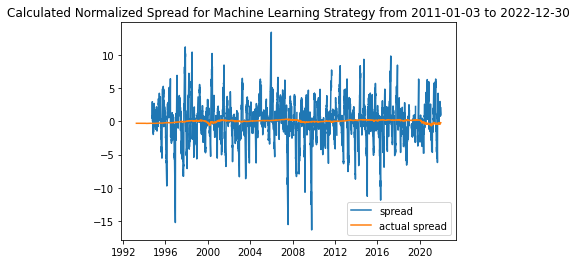

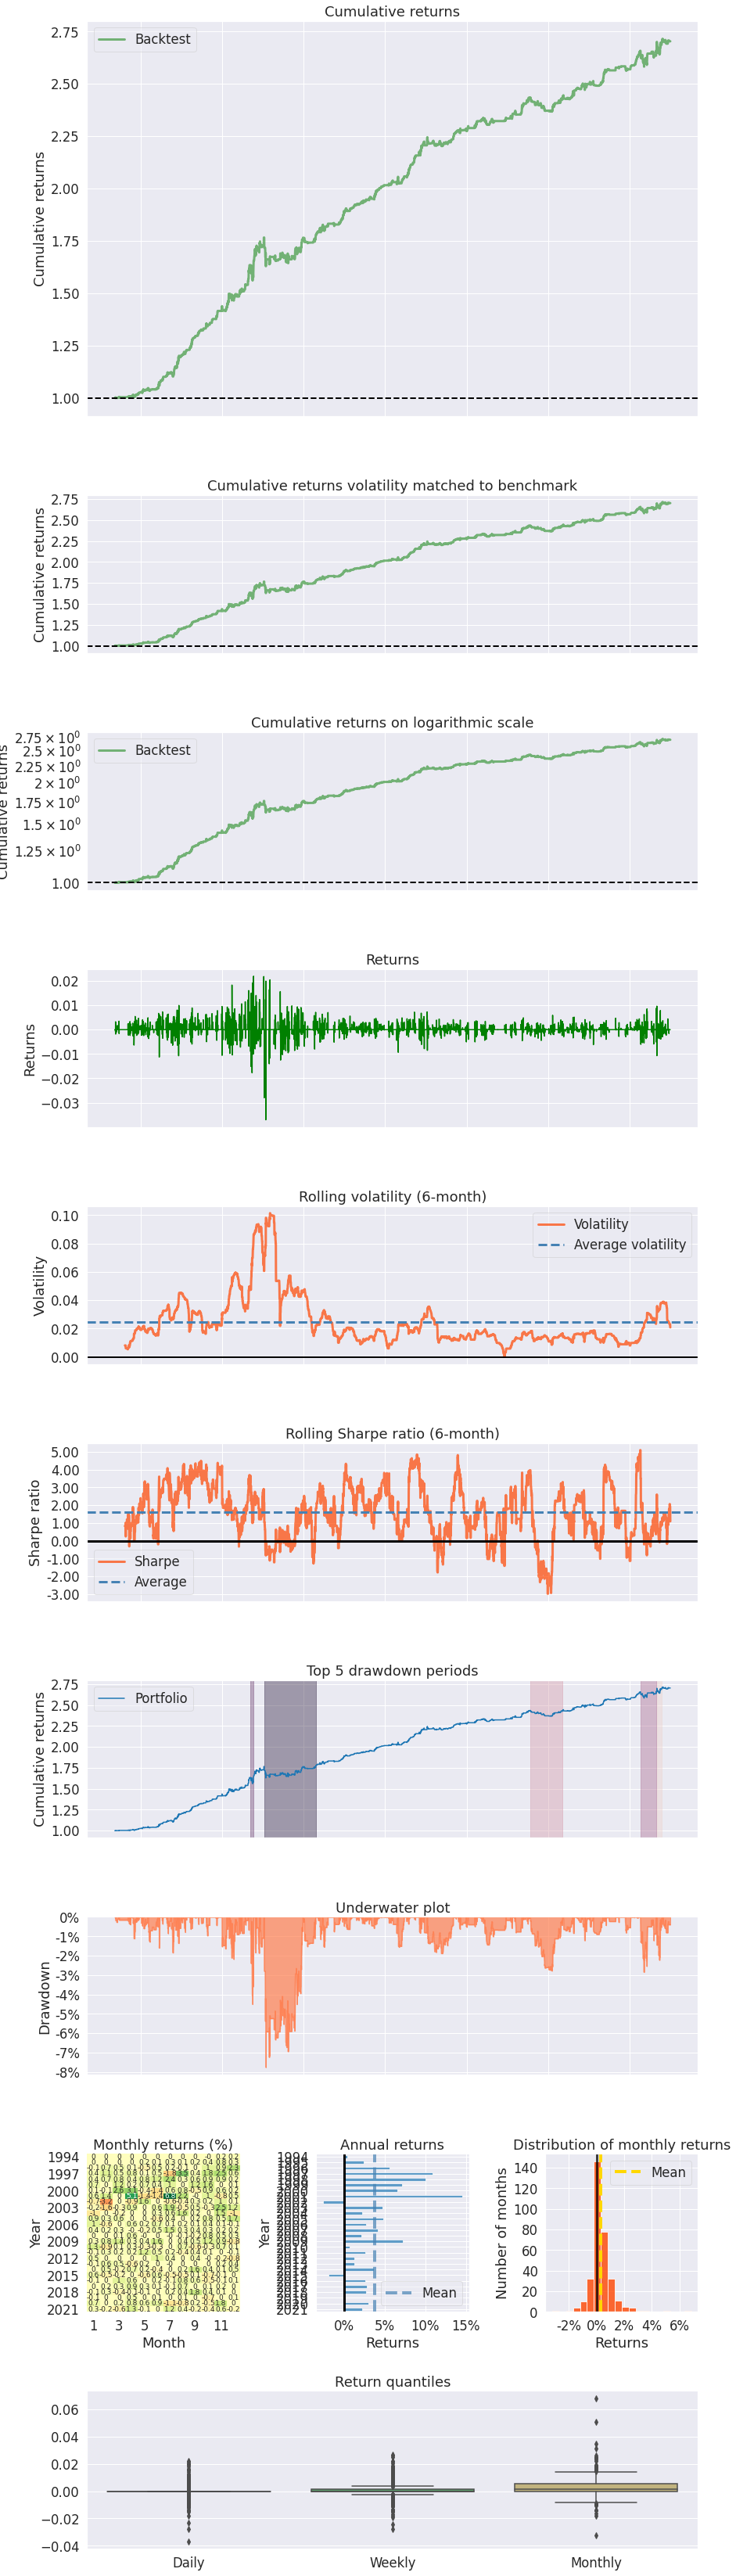

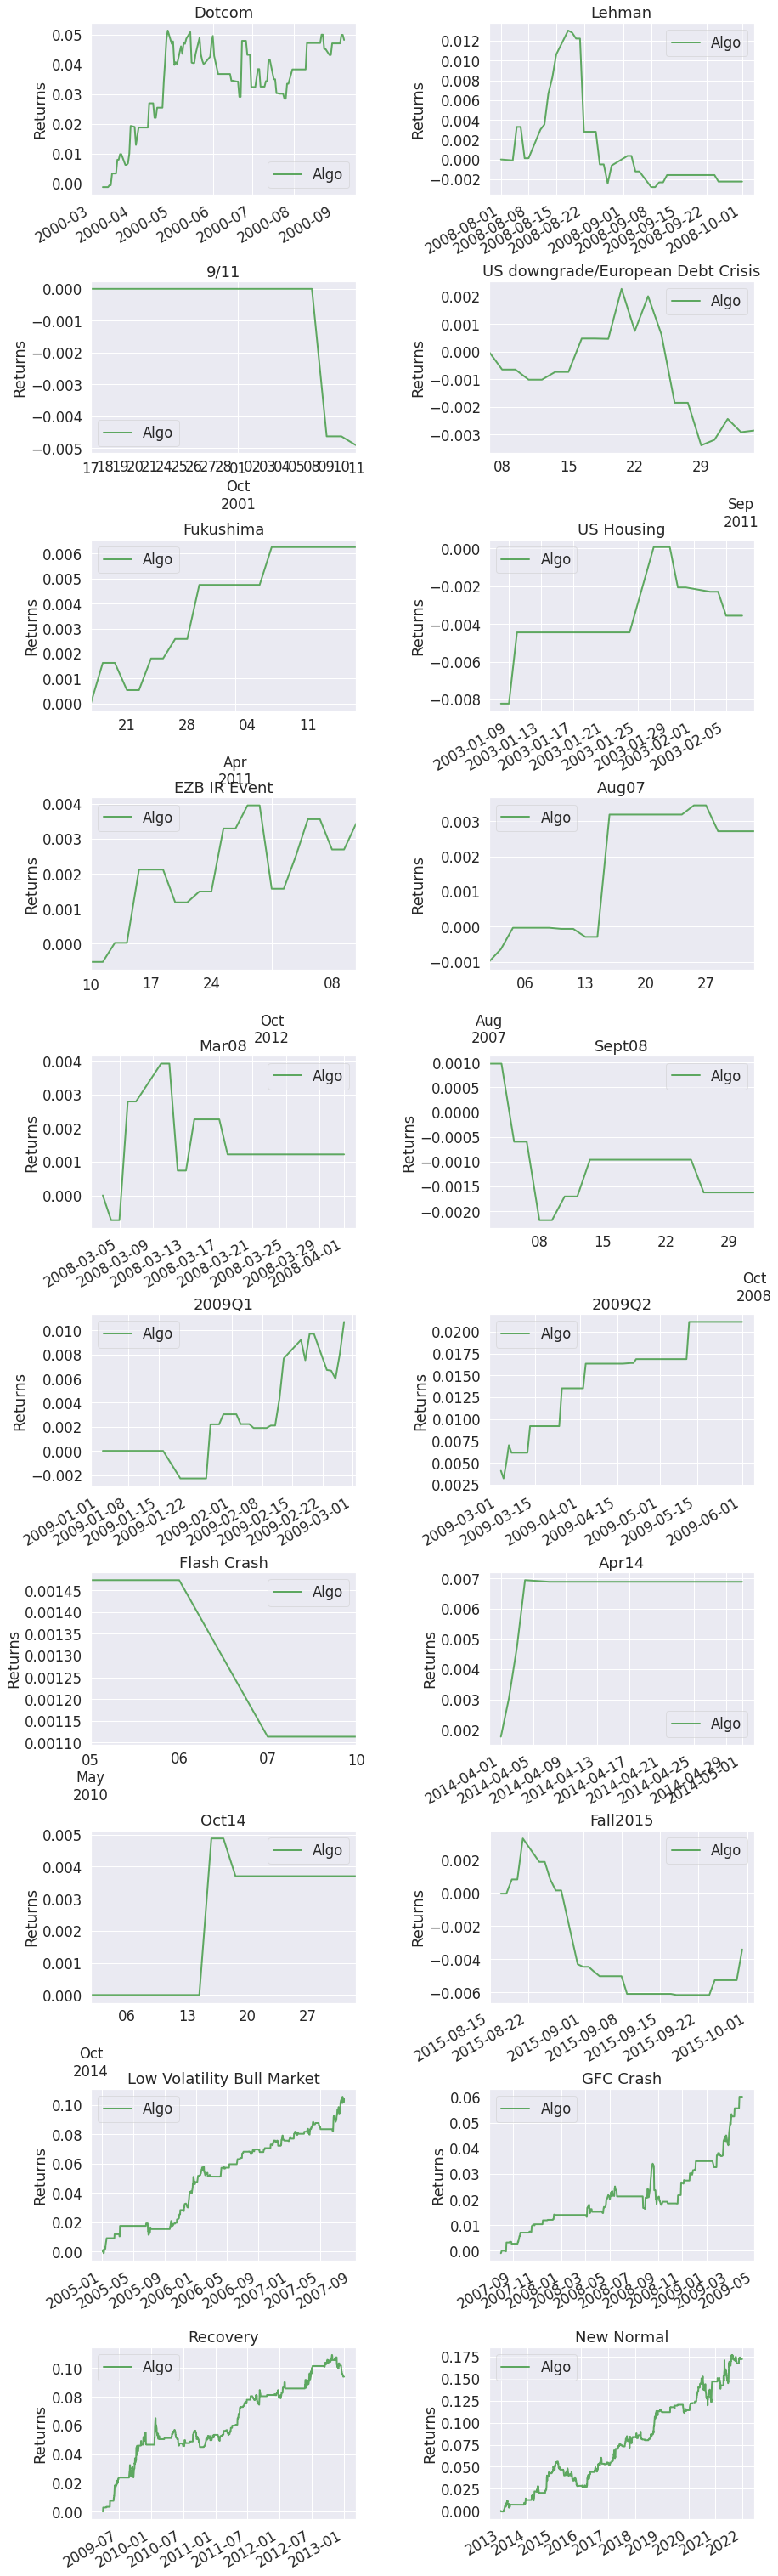

In [13]:
# simple run without risk management
all_returns = []
all_spread = []
i = 0
while(i < len(x)- formation - trading_period):
    x_train, x_test = x[i:i+formation], x[i+formation:i+formation+trading_period]
    y_train, y_test = y[i:i+formation], y[i+formation:i+formation+trading_period]  
    temp_spread, strategy = get_strategy_copula(x_train, y_train, x_test, y_test, isconver=False)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)
    i += trading_period

dates = np.asarray(price_data.index.values[formation:], dtype='datetime64[s]')
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(dates[-len(all_spread):], all_spread, label = 'spread')
plt.plot(dates, actual_spread[formation:], label = 'actual spread')
plt.title('Calculated Normalized Spread for Machine Learning Strategy from 2011-01-03 to 2022-12-30')
plt.legend()

dates = pd.to_datetime(price_data.index.values[formation:])
rets = pd.Series(data = all_returns, index = dates[-len(all_spread):])
rets = rets.tz_localize('UTC')
fig = pf.create_full_tear_sheet(returns=rets)

<ipython-input-10-ad17cb74b6f1>:44: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf)
<ipython-input-10-ad17cb74b6f1>:85: RuntimeWarning: overflow encountered in add
  loglikelihood = sum(lpdf)
<ipython-input-10-ad17cb74b6f1>:44: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf)
<ipython-input-10-ad17cb74b6f1>:85: RuntimeWarning: overflow encountered in add
  loglikelihood = sum(lpdf)
<ipython-input-10-ad17cb74b6f1>:42: RuntimeWarning: divide by zero encountered in power
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
<ipython-input-10-ad17cb74b6f1>:42: RuntimeWarning: invalid value encountered in multiply
  pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
<ipython-input-10-ad17cb74b6f1>:44: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf)
<ipython-in

Start date,1994-09-22
End date,2021-12-31
Total months,325
,Backtest
Annual return,4.583%
Cumulative returns,237.442%
Annual volatility,2.993%
Sharpe ratio,1.51
Calmar ratio,0.72
Stability,0.95
Max drawdown,-6.321%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.32,2002-02-19,2002-03-11,2002-11-11,190
1,4.18,1999-12-28,2000-03-14,2000-06-13,121
2,3.60,2003-08-05,2003-11-06,2004-08-02,260
3,2.96,1999-03-24,1999-06-18,1999-09-13,124
4,2.77,2020-08-18,2020-09-16,2020-11-11,62


c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
c:\Users\Lakshay Garg\Anaconda3\lib\site-packages\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will rai

Stress Events,mean,min,max
Dotcom,0.04%,-0.62%,1.30%
Lehman,0.02%,-0.33%,0.34%
9/11,-0.01%,-0.84%,0.82%
US downgrade/European Debt Crisis,-0.01%,-0.25%,0.18%
Fukushima,0.05%,-0.11%,0.26%
US Housing,-0.04%,-0.82%,0.38%
EZB IR Event,0.01%,-0.25%,0.18%
Aug07,0.02%,-0.10%,0.22%
Mar08,0.01%,-0.32%,0.35%
Sept08,-0.01%,-0.16%,0.10%


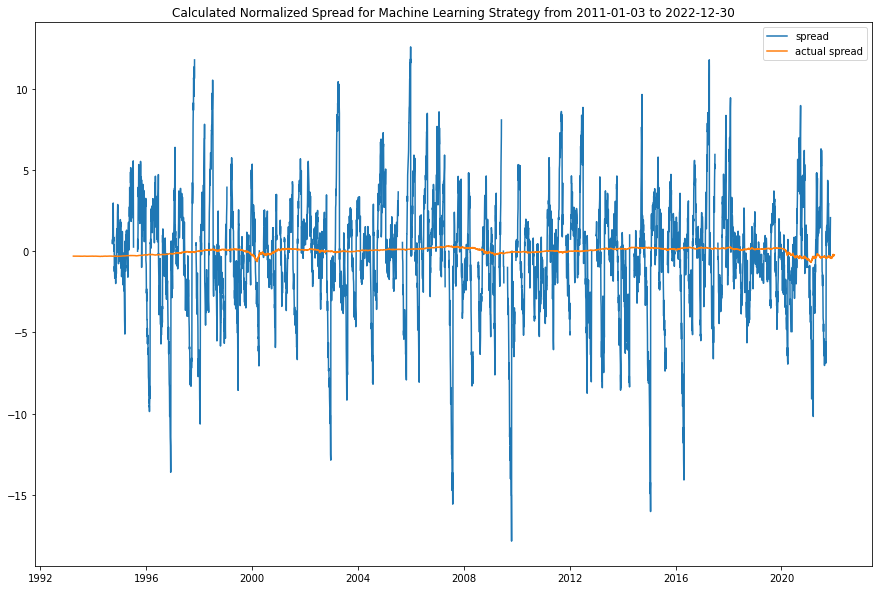

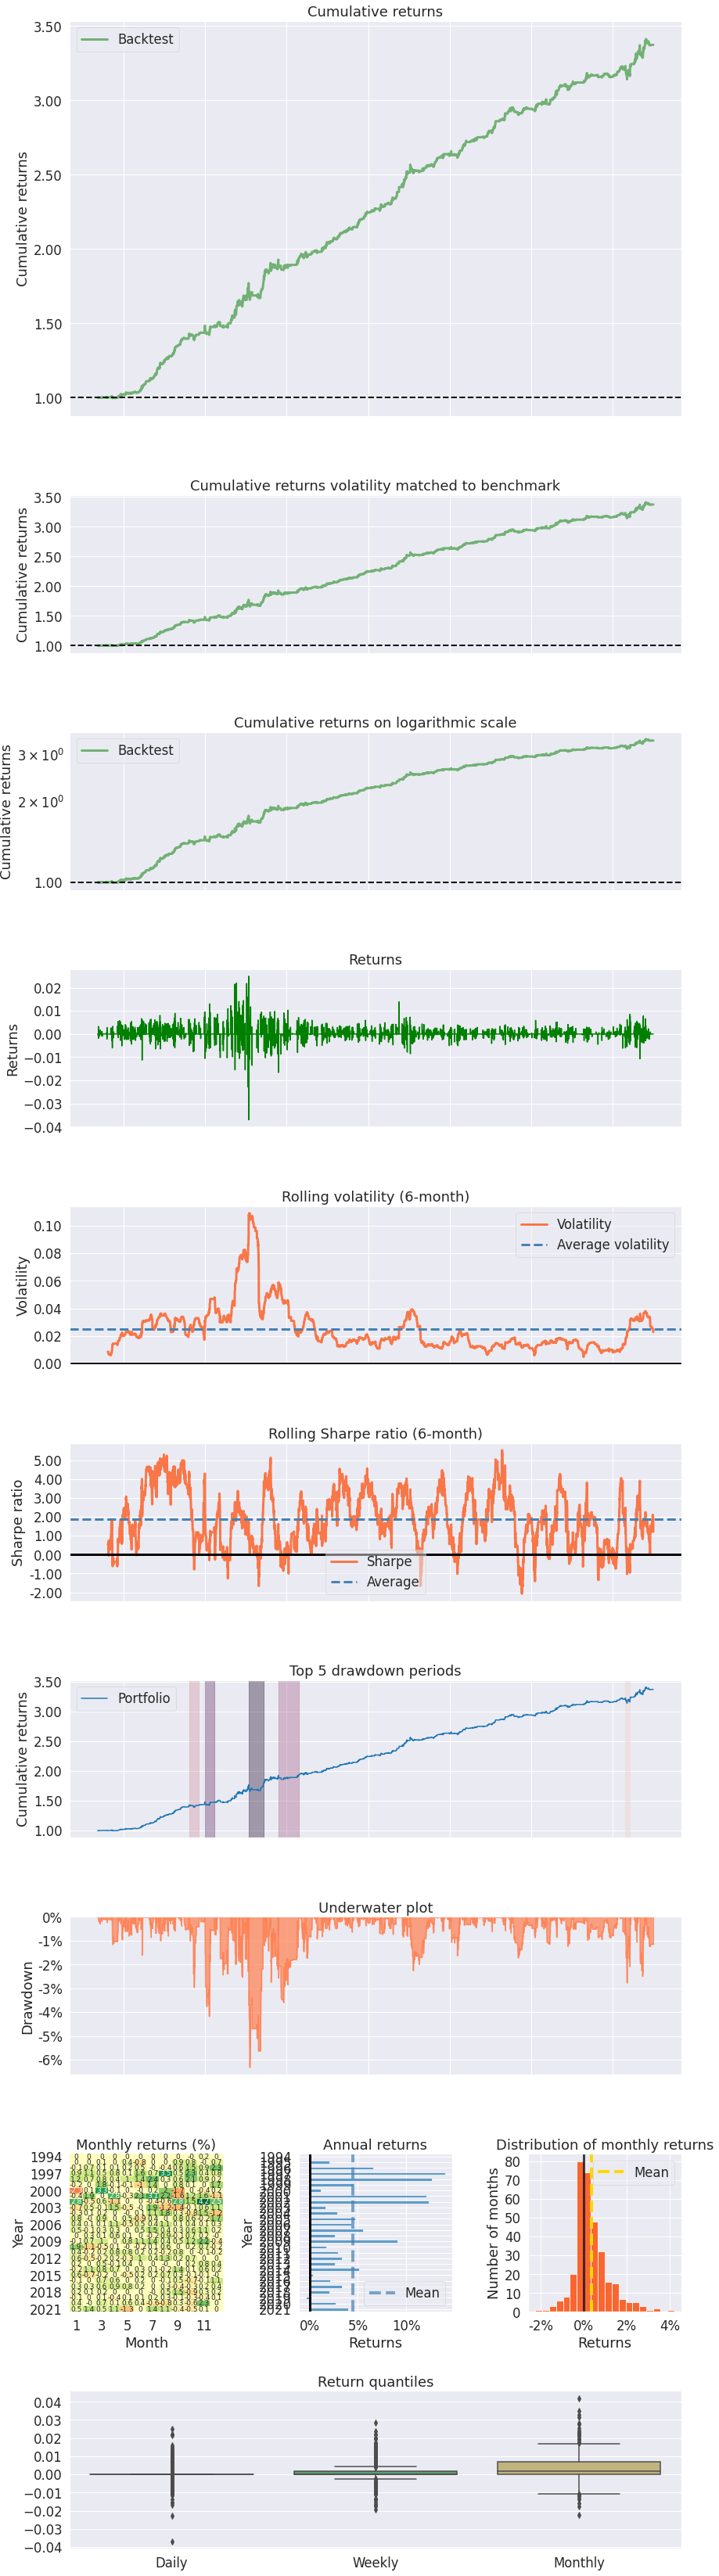

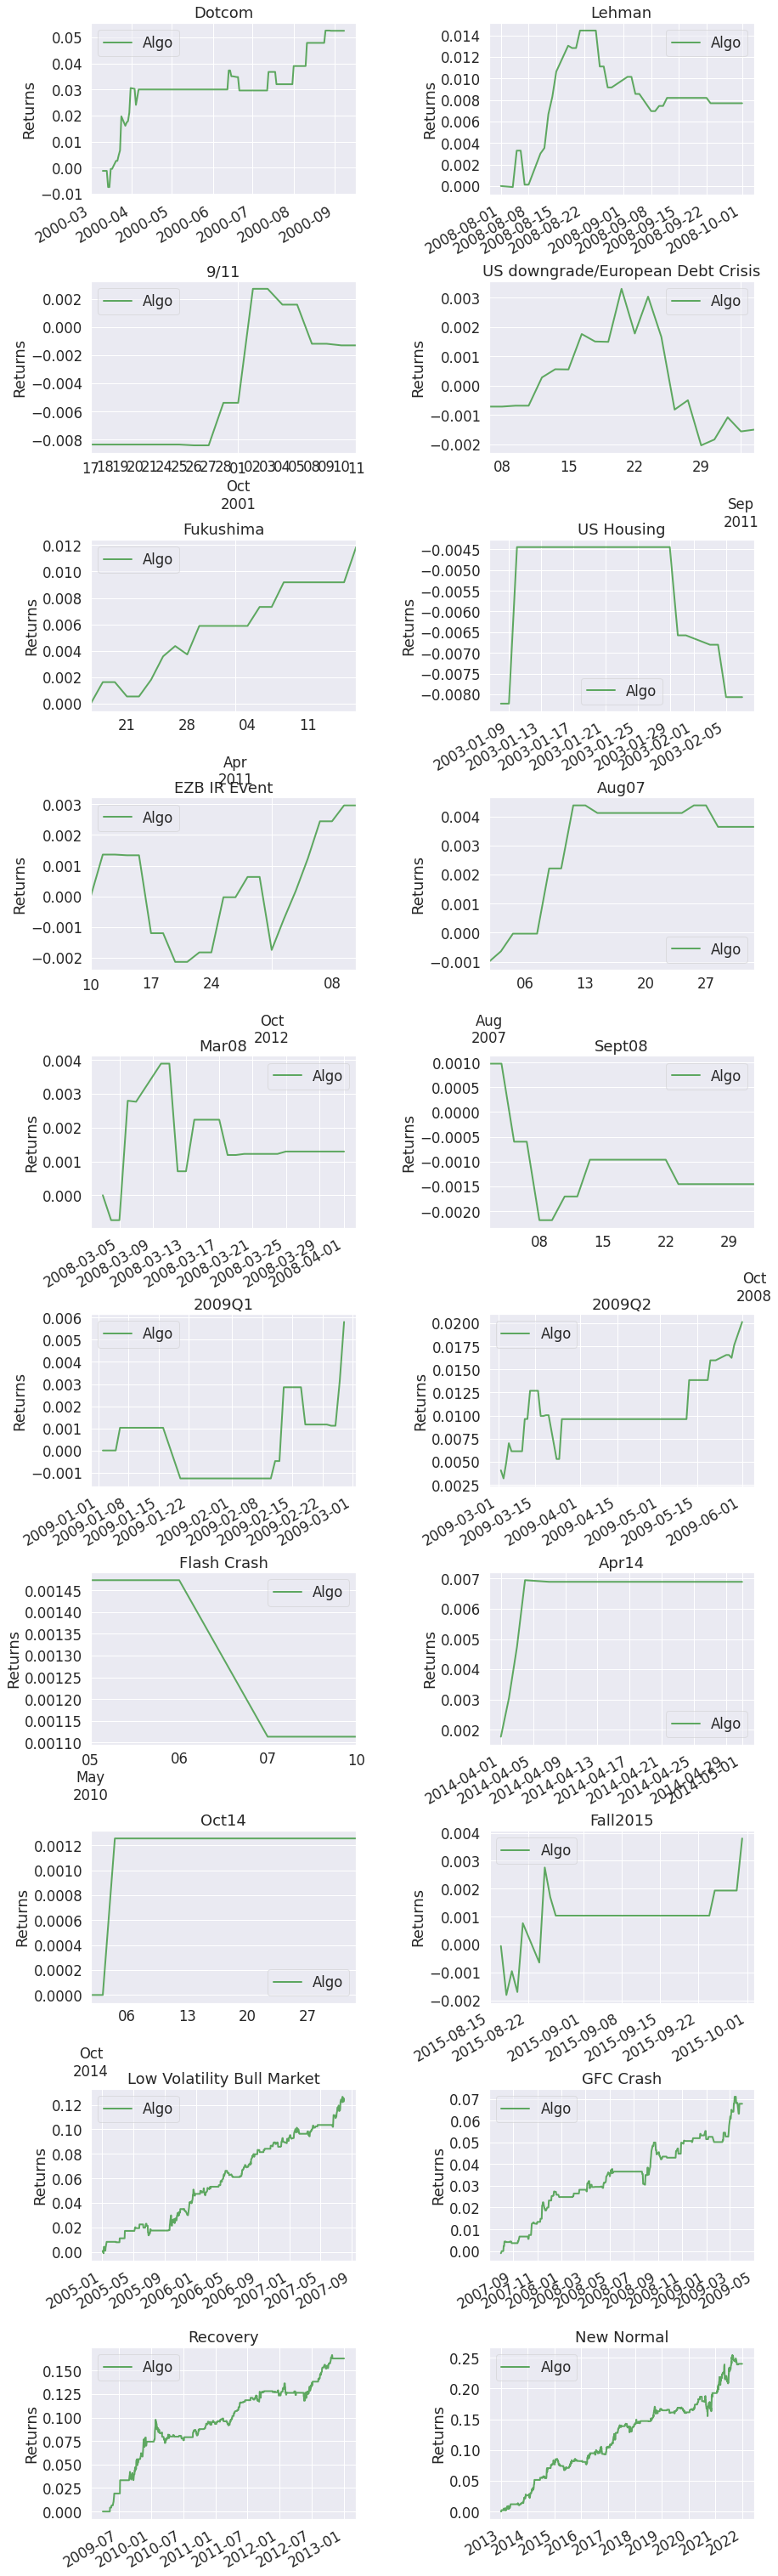

In [17]:
# simple run without risk management
all_returns = []
all_spread = []
i = 0
while(i < len(x)- formation - trading_period):
    x_train, x_test = x[i:i+formation], x[i+formation:i+formation+trading_period]
    y_train, y_test = y[i:i+formation], y[i+formation:i+formation+trading_period]  
    temp_spread, strategy = get_strategy_copula2(x_train, y_train, x_test, y_test, isconver=False)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)
    i += trading_period

dates = np.asarray(price_data.index.values[formation:], dtype='datetime64[s]')
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(dates[-len(all_spread):], all_spread, label = 'spread')
plt.plot(dates, actual_spread[formation:], label = 'actual spread')
plt.title('Calculated Normalized Spread for Machine Learning Strategy from 2011-01-03 to 2022-12-30')
plt.legend()

dates = pd.to_datetime(price_data.index.values[formation:])
rets = pd.Series(data = all_returns, index = dates[-len(all_spread):])
rets = rets.tz_localize('UTC')
fig = pf.create_full_tear_sheet(returns=rets)

In [ ]:
# with risk management
all_returns = []
all_spread = []
i = 0
while(i < len(x)- formation - trading_period):
    x_train, x_test = x[i:i+formation], x[i+formation:i+formation+trading_period]
    y_train, y_test = y[i:i+formation], y[i+formation:i+formation+trading_period]
    alter_train, alter_test = alter_data[i:i+formation,:], alter_data[i+formation:i+formation+trading_period,:]
    temp_spread, strategy = get_strategy_copula_rm(x_train, y_train, x_test, y_test, \
                                                   alter_train, alter_test, isconver=False)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)
    i += trading_period

dates = np.asarray(price_data.index.values[formation:], dtype='datetime64[s]')
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(dates[-len(all_spread):], all_spread, label = 'spread')
plt.plot(dates, actual_spread[formation:], label = 'actual spread')
plt.title('Calculated Normalized Spread for Machine Learning Strategy from 2011-01-03 to 2022-12-30')
plt.legend()

dates = pd.to_datetime(price_data.index.values[formation:])
rets = pd.Series(data = all_returns, index = dates[-len(all_spread):])
rets = rets.tz_localize('UTC')
pf.create_full_tear_sheet(returns=rets,)